## Import and installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers==4.28.0 datasets evaluate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.28.0 which is in

In [ ]:
!pip install datasets
!pip install evaluate

In [ ]:
!pip install --upgrade transformers



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.0
    Uninstalling transformers-4.28.0:
      Successfully uninstalled transformers-4.28.0


In [ ]:
from datasets import ClassLabel, Features, Dataset
from transformers import (BertTokenizer, BertForSequenceClassification,
                          Trainer, TrainingArguments,
                          DataCollatorWithPadding, TextClassificationPipeline)
import pandas as pd
from tqdm.auto import tqdm
import torch
import pickle
import numpy as np
import evaluate

In [ ]:
id2label = {n: tag for n, tag in enumerate([
    "lex",
    "ortho",
    "gov",
    "syntax",
    "asp",
    "prep",
    "constr",
    "ref",
    "agrcase",
    "conj",
    "punct",
    "agrgender",
    "agrnum",
    "num",
    "infl",
    "wo",
    "tense",
    "misspell",
    "brev",
    "gender",
    "deriv",
    "agrpers",
    "refl"
])}



label2id = {n : tag for tag, n in id2label.items()}

In [ ]:
label2id

{'lex': 0,
 'ortho': 1,
 'gov': 2,
 'syntax': 3,
 'asp': 4,
 'prep': 5,
 'constr': 6,
 'ref': 7,
 'agrcase': 8,
 'conj': 9,
 'punct': 10,
 'agrgender': 11,
 'agrnum': 12,
 'num': 13,
 'infl': 14,
 'wo': 15,
 'tense': 16,
 'misspell': 17,
 'brev': 18,
 'gender': 19,
 'deriv': 20,
 'agrpers': 21,
 'refl': 22}

In [ ]:
id2label

{0: 'lex',
 1: 'ortho',
 2: 'gov',
 3: 'syntax',
 4: 'asp',
 5: 'prep',
 6: 'constr',
 7: 'ref',
 8: 'agrcase',
 9: 'conj',
 10: 'punct',
 11: 'agrgender',
 12: 'agrnum',
 13: 'num',
 14: 'infl',
 15: 'wo',
 16: 'tense',
 17: 'misspell',
 18: 'brev',
 19: 'gender',
 20: 'deriv',
 21: 'agrpers',
 22: 'refl'}

## Preprocessing

In [ ]:
data = pd.read_csv('dataset_full_sentences_context.csv')
data

,text,tag
0,окружющей → окружающей | Одной из самых главны...,ortho
1,промышленным → промышленных | Уровень загрязне...,agrcase
2,воздействую → воздействуя | Этот металл может ...,syntax
3,желудожно-кишечный → желудочно-кишечный | Этот...,"ortho, altern"
4,это → | Основной путь попадания свинца в орг...,syntax
...,...,...
38920,"Они → Им | Они были тяжело в Америке, потому ч...",gov
38921,"были → было | Они были тяжело в Америке, потом...",agrnum
38922,"[MASK] → у | Они были тяжело в Америке, потому...",prep
38923,"[MASK] → них | Они были тяжело в Америке, пото...",ref


In [ ]:
data = data.dropna()

In [ ]:

def split_tags(row):
    tags = row['tag'].split(',')
    return pd.DataFrame({'text': row['text'], 'tag': tags})


data = pd.concat(data.apply(split_tags, axis=1).tolist(), ignore_index=True)


print(data)

                                                    text      tag
0      окружющей → окружающей | Одной из самых главны...    ortho
1      промышленным → промышленных | Уровень загрязне...  agrcase
2      воздействую → воздействуя | Этот металл может ...   syntax
3      желудожно-кишечный → желудочно-кишечный | Этот...    ortho
4      желудожно-кишечный → желудочно-кишечный | Этот...   altern
...                                                  ...      ...
45418  Они → Им | Они были тяжело в Америке, потому ч...      gov
45419  были → было | Они были тяжело в Америке, потом...   agrnum
45420  [MASK] → у | Они были тяжело в Америке, потому...     prep
45421  [MASK] → них | Они были тяжело в Америке, пото...      ref
45422  в вуз экзаменами → экзаменами в вуз | Это было...       wo

[45423 rows x 2 columns]


In [ ]:
tag_counts = data['tag'].value_counts()
tag_counts

,count
tag,
lex,7242
syntax,5602
ortho,4297
gov,2822
prep,1769
...,...
рецензией,1
insert,1
addw,1


delete tags with counts < 200

In [ ]:
data['tag'] = data['tag'].str.strip()


data['tag'] = data['tag'].str.lower()


tag_counts = data['tag'].value_counts()


data = data[data['tag'].map(tag_counts) >= 200]

tag_counts = data['tag'].value_counts()


print(tag_counts)

tag
lex          8140
syntax       5732
ortho        4643
gov          3426
constr       2859
prep         2214
ref          1890
asp          1487
conj         1406
agrcase      1291
agrnum       1163
wo           1109
agrgender    1092
num          1033
infl          974
punct         854
tense         601
space         553
misspell      418
brev          371
deriv         358
gender        328
refl          305
agrpers       297
hyphen        255
par           251
idiom         249
agrstr        245
aux           245
impers        222
Name: count, dtype: int64


In [ ]:
data['label'] = data['tag'].map(label2id)

In [ ]:
data

,text,tag,label
0,окружющей → окружающей | Одной из самых главны...,ortho,1.0
1,промышленным → промышленных | Уровень загрязне...,agrcase,8.0
2,воздействую → воздействуя | Этот металл может ...,syntax,3.0
3,желудожно-кишечный → желудочно-кишечный | Этот...,ortho,1.0
5,это → | Основной путь попадания свинца в орг...,syntax,3.0
...,...,...,...
45418,"Они → Им | Они были тяжело в Америке, потому ч...",gov,2.0
45419,"были → было | Они были тяжело в Америке, потом...",agrnum,12.0
45420,"[MASK] → у | Они были тяжело в Америке, потому...",prep,5.0
45421,"[MASK] → них | Они были тяжело в Америке, пото...",ref,7.0


In [ ]:
data = data.dropna()

In [ ]:
!pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Fine-tuning Roberta

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

class TextDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.texts = data['text'].values
        self.labels = data['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }


class RobertaWithAttention(nn.Module):
    def __init__(self, num_labels):
        super(RobertaWithAttention, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.attention = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, 1),
            nn.Tanh()
        )
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        attention_scores = self.attention(hidden_states).squeeze(-1)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_hidden_states = torch.sum(hidden_states * attention_weights.unsqueeze(-1), dim=1)


        logits = self.classifier(weighted_hidden_states)
        return logits


def train_and_evaluate(data, num_labels, num_epochs=10, batch_size=8, max_len=128, lr=2e-5, save_dir="saved_models"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используемое устройство: {device}")

    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    dataset = TextDataset(data, tokenizer, max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


    model = RobertaWithAttention(num_labels=num_labels).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct_top3 = 0
        total_samples = 0
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        for batch in tqdm(dataloader, desc="Training", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()


            top3_preds = torch.topk(logits, 3, dim=1).indices
            correct_top3 += sum([label in preds for label, preds in zip(labels.tolist(), top3_preds.tolist())])
            total_samples += labels.size(0)

        epoch_accuracy = correct_top3 / total_samples
        print(f"Loss: {epoch_loss / len(dataloader):.4f}, Top-3 Accuracy: {epoch_accuracy:.4f}")


        model_path = os.path.join(save_dir, f"model_5words_08_04_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}")

    return model

if __name__ == "__main__":

    data = data


    model = train_and_evaluate(data, num_labels=data['label'].nunique())

    MODEL_PATH = '/content/drive/MyDrive/models/trained_model_5words_08_04.pth'



    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Модель сохранена в {MODEL_PATH}")


Используемое устройство: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Loss: 1.8251, Top-3 Accuracy: 0.6863
Model saved at saved_models/model_5words_08_04_epoch_1.pth

Epoch 2/10


Loss: 1.3806, Top-3 Accuracy: 0.8050
Model saved at saved_models/model_5words_08_04_epoch_2.pth

Epoch 3/10


Loss: 1.2734, Top-3 Accuracy: 0.8317
Model saved at saved_models/model_5words_08_04_epoch_3.pth

Epoch 4/10


Loss: 1.1855, Top-3 Accuracy: 0.8526
Model saved at saved_models/model_5words_08_04_epoch_4.pth

Epoch 5/10


Loss: 1.1351, Top-3 Accuracy: 0.8660
Model saved at saved_models/model_5words_08_04_epoch_5.pth

Epoch 6/10


Loss: 1.0967, Top-3 Accuracy: 0.8741
Model saved at saved_models/model_5words_08_04_epoch_6.pth

Epoch 7/10


Loss: 1.0514, Top-3 Accuracy: 0.8841
Model saved at saved_models/model_5words_08_04_epoch_7.pth

Epoch 8/10


Loss: 1.0214, Top-3 Accuracy: 0.8901
Model saved at saved_models/model_5words_08_04_epoch_8.pth

Epoch 9/10


Loss: 0.9849, Top-3 Accuracy: 0.8979
Model saved at saved_models/model_5words_08_04_epoch_9.pth

Epoch 10/10


Loss: 0.9732, Top-3 Accuracy: 0.9006
Model saved at saved_models/model_5words_08_04_epoch_10.pth
Модель сохранена в /content/drive/MyDrive/models/trained_model_5words_08_04.pth


In [ ]:

torch.save(model.state_dict(), "trained_model_5words_04_04.pth")

## Testing on test data

In [ ]:
import torch
import pandas as pd
from transformers import RobertaTokenizer

MODEL_PATH = '/content/drive/MyDrive/models/trained_model_5words_08_04.pth'
TOKENIZER_PATH = "roberta-base"
OUTPUT_FILE = "rlc_test_full_context_llm_errant_marked.csv"


def load_model(model_path, num_labels):
    model = RobertaWithAttention(num_labels=num_labels)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model


def predict(model, tokenizer, text, max_len=128, top_k=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    encoding = tokenizer(
        text,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=1).squeeze(0)


        top_probs, top_indices = torch.topk(probabilities, k=top_k)
        top_probs = top_probs.cpu().numpy()
        top_indices = top_indices.cpu().numpy()

    return top_indices, top_probs


if __name__ == "__main__":

    allowed_tags = [
        "lex",
        "ortho",
        "gov",
        "syntax",
        "asp",
        "prep",
        "constr",
        "ref",
        "agrcase",
        "conj",
        "punct",
        "agrgender",
        "agrnum",
        "num",
        "infl",
        "wo",
        "tense",
        "misspell",
        "brev",
        "gender",
        "deriv",
        "agrpers",
        "refl"
    ]

    id2label = {n: tag for n, tag in enumerate(allowed_tags)}  # Use allowed_tags

    num_labels = len(allowed_tags) # Set num_labels based on the length of allowed_tags


    input_file = "rlc_test_full_context_llm_errant.csv"
    data = pd.read_csv(input_file)
    data['tag'] = data['tag'].str.lower()  # Ensure tags are lowercase for comparison
    data = data.dropna()

    # Filter out rows where the 'tag' is not in 'allowed_tags'
    data = data[data['tag'].isin(allowed_tags)]

    tokenizer = RobertaTokenizer.from_pretrained(TOKENIZER_PATH)
    model = load_model(MODEL_PATH, num_labels)


    predictions = []
    for text in data["text"]:
        top_indices, top_probs = predict(model, tokenizer, text, top_k=3)
        top_labels = [id2label[idx] for idx in top_indices]
        predictions.append(", ".join([f"{label} ({prob:.4f})" for label, prob in zip(top_labels, top_probs)]))

    data["top_3_predictions"] = predictions

    data.to_csv(OUTPUT_FILE, index=False)
    print(f"Результаты сохранены в файл: {OUTPUT_FILE}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Результаты сохранены в файл: rlc_test_full_context_llm_errant_marked.csv


In [ ]:
data

,text,tag,top_3_predictions
1,готовить → готовит | Мама готовить вкусно и я ...,ortho,"ortho (0.3116), agrpers (0.1405), agrnum (0.0873)"
2,"говорем → говорим | Там мы говорем с друзами, ...",infl,"ortho (0.3076), gov (0.1305), infl (0.1215)"
3,"друзами → друзьями | Там мы говорем с друзами,...",infl,"ortho (0.3018), infl (0.2888), gov (0.0668)"
4,"здание → задания | Там мы говорем с друзами, д...",ortho,"gov (0.3825), num (0.2120), agrcase (0.0864)"
5,"согласин → согласен | Я согласин, что есть чит...",ortho,"ortho (0.6862), infl (0.0966), asp (0.0314)"
...,...,...,...
486,mask → которое | А в китайском есть выражение ...,ref,"ref (0.2308), gov (0.1674), gender (0.1151)"
487,такой-же → такое же | А в китайском есть выраж...,agrgender,"agrgender (0.5894), agrcase (0.1041), gov (0.0..."
488,самосазнанием → самосознанием | Личность - это...,ortho,"ortho (0.8690), lex (0.0269), gov (0.0255)"
489,из → от | Все люди должны любить и получать лю...,prep,"prep (0.6585), gov (0.0787), lex (0.0534)"


## Confusion matrix

for 1 prediction

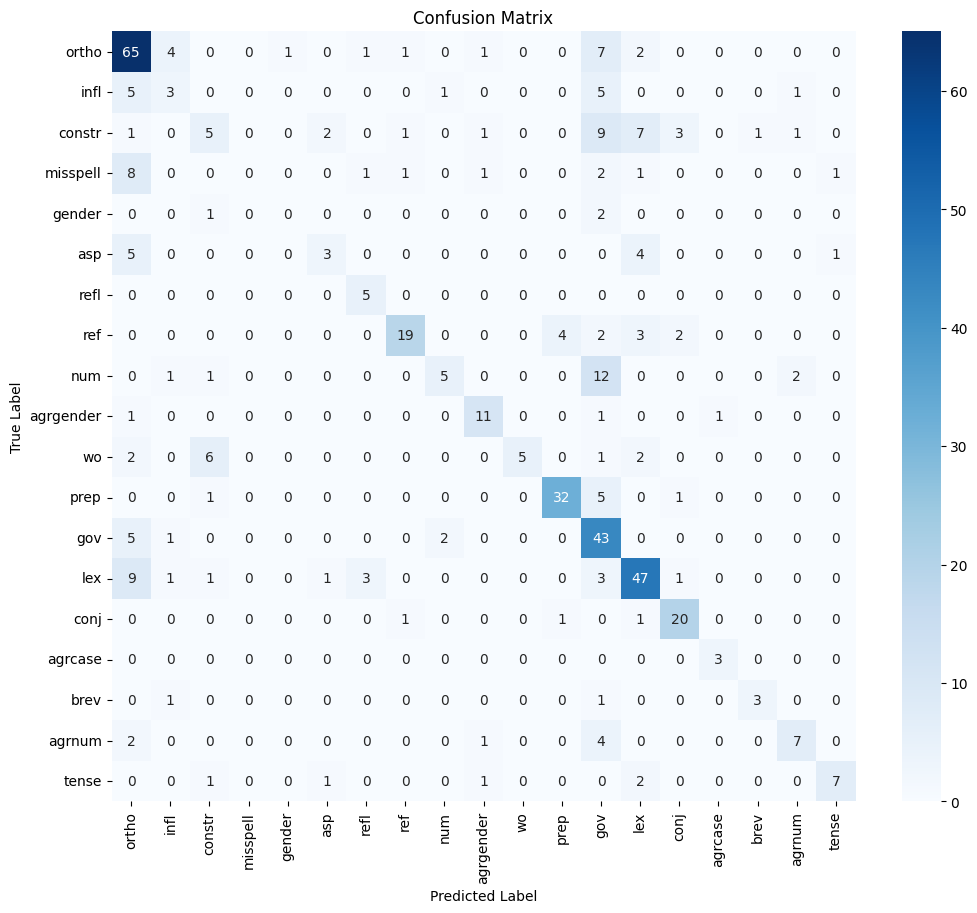

Classification Metrics:
              precision    recall  f1-score     support
agrcase        0.750000  1.000000  0.857143    3.000000
agrgender      0.687500  0.785714  0.733333   14.000000
agrnum         0.636364  0.500000  0.560000   14.000000
asp            0.428571  0.214286  0.285714   14.000000
brev           0.750000  0.600000  0.666667    5.000000
conj           0.740741  0.869565  0.800000   23.000000
constr         0.312500  0.147059  0.200000   34.000000
gender         0.000000  0.000000  0.000000    3.000000
gov            0.443299  0.843137  0.581081   51.000000
infl           0.272727  0.200000  0.230769   15.000000
lex            0.681159  0.701493  0.691176   67.000000
misspell       0.000000  0.000000  0.000000   15.000000
num            0.625000  0.238095  0.344828   21.000000
ortho          0.631068  0.773810  0.695187   84.000000
prep           0.864865  0.820513  0.842105   39.000000
ref            0.826087  0.612903  0.703704   31.000000
refl           0.500000 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("rlc_test_full_context_llm_errant_marked.csv")


def extract_top_prediction(row):
    top_3_predictions = row.split(", ")
    top_prediction = top_3_predictions[0].split(" ")[0]
    return top_prediction


data["predicted_tag"] = data["top_3_predictions"].apply(extract_top_prediction)


true_labels = data["tag"]
predicted_labels = data["predicted_tag"]


conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=true_labels.unique())
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=true_labels.unique(), yticklabels=true_labels.unique(), cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()


print("Classification Metrics:")
print(report_df)


report_df.to_csv("classification_report.csv", index=True)


for 3 prediction

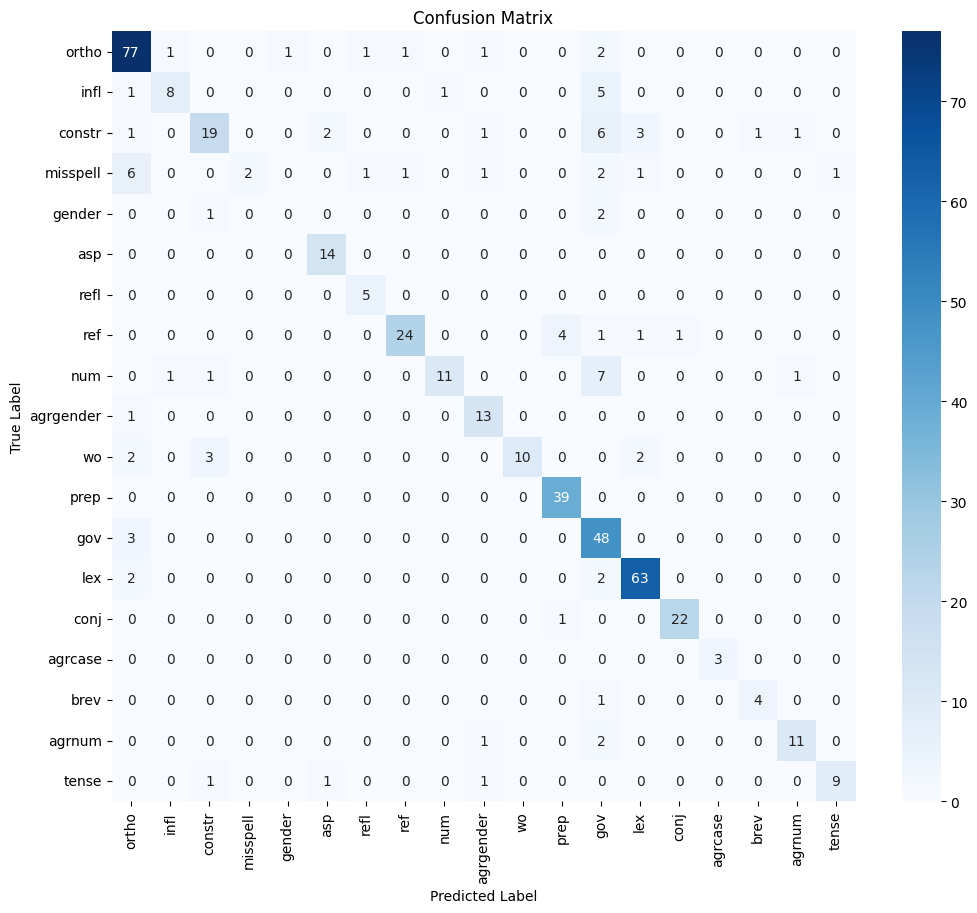

Classification Metrics:
              precision    recall  f1-score     support
agrcase        1.000000  1.000000  1.000000    3.000000
agrgender      0.722222  0.928571  0.812500   14.000000
agrnum         0.846154  0.785714  0.814815   14.000000
asp            0.823529  1.000000  0.903226   14.000000
brev           0.800000  0.800000  0.800000    5.000000
conj           0.956522  0.956522  0.956522   23.000000
constr         0.760000  0.558824  0.644068   34.000000
gender         0.000000  0.000000  0.000000    3.000000
gov            0.615385  0.941176  0.744186   51.000000
infl           0.800000  0.533333  0.640000   15.000000
lex            0.900000  0.940299  0.919708   67.000000
misspell       1.000000  0.133333  0.235294   15.000000
num            0.916667  0.523810  0.666667   21.000000
ortho          0.827957  0.916667  0.870056   84.000000
prep           0.886364  1.000000  0.939759   39.000000
ref            0.923077  0.774194  0.842105   31.000000
refl           0.714286 

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv("rlc_test_full_context_llm_errant_marked.csv")


def extract_predicted_tag(row):
    true_tag = row['tag']
    top_3_predictions = row['top_3_predictions'].split(", ")

    for prediction in top_3_predictions:
        predicted_tag = prediction.split(" ")[0]
        if predicted_tag == true_tag:
            return predicted_tag

    return top_3_predictions[0].split(" ")[0]


data["predicted_tag"] = data.apply(extract_predicted_tag, axis=1)


true_labels = data["tag"]
predicted_labels = data["predicted_tag"]

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=true_labels.unique())
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=true_labels.unique(), yticklabels=true_labels.unique(), cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()


print("Classification Metrics:")
print(report_df)


report_df.to_csv("classification_report.csv", index=True)